In [1]:
#!pip install packaging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from packaging import version

assert(version.parse(tf.__version__) >= version.parse("2.0.0-aplha"))

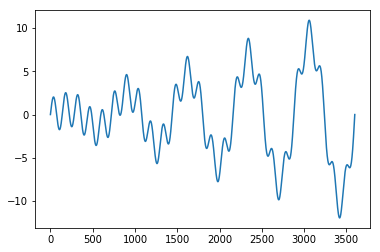

180


In [62]:
#t = np.arange(0., 10.*np.pi, np.pi / 360)
t = np.arange(0, 3601) * np.pi / 360.
data = np.array(t * np.sin(t)/3. + 2.*np.sin(t * 5.), dtype=np.float32)
#spt_data = np.reshape(data[:3600], (-1, 20, 2))
#spt_lbl = np.reshape(data[1:3601], (-1, 20, 2))
spt_data = np.array(np.reshape(data[:3600], (-1, 20, 1)))
spt_lbl = np.array(np.reshape(data[1:3601], (-1, 20, 1)))

#print(len(spt_data[0]))
#print(len(spt_lbl [0]))
#print(spt_data[0])
#print(spt_lbl [0])

#print(len(t))
#plt.plot(t)
#plt.show()
plt.plot(data)
#plt.plot(spt_data)
plt.show()
print(len(spt_data))

In [64]:
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices([spt_data, spt_lbl])
dataset = dataset.batch(BATCH_SIZE)

#for i in dataset : print(i)


In [4]:
class Encoder(tf.keras.Model):
  def __init__(self, enc_units, batch_sz) : #, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    #self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    #self.inputi = tf.keras.Input(shape=(1,))
    #self.input_shape = tf.TensorShape([None,1])
    self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   #return_state=True,
                                   stateful=True,
                                   recurrent_initializer='glorot_uniform')
    #self.gru = tf.keras.layers.RNN(
    #    tf.keras.layers.GRUCell(self.enc_units,
    #                               recurrent_initializer='glorot_uniform'),
    #   return_sequences=True,
    #   return_state=True
    #)
    
  def call(self, x, initial_state=None): #, hidden):
    #print(x, initial_state)
    #x2 = self.inputi(x)
    #print(x2)
    if (initial_state!=None) :
        self.lstm.reset_states(initial_state)
    
    output = self.lstm(x) #, initial_state = hidden)
    #output, self.state = self.lstm(x, self.state) #, initial_state = hidden)
    return output #, state

  #def reset_states(self) :
  #  self.lstm.reset_states()

  def reset_states(self, initial_state=None) :
    print(self.lstm.input_spec)
    self.lstm.reset_states(initial_state)

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))
 

In [69]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.MeanSquaredError()
mask = np.concatenate((
    np.zeros((15,1), dtype=np.float32), 
    np.ones((5,1), dtype=np.float32)))
#print(mask)

def loss_function(real, pred):
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    print(loss_)

    #mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    print(loss_)

    return tf.reduce_mean(loss_)


In [14]:
#BATCH_SIZE = 64
#f = dataset.take(1)
#print(f.shape)
f = next(iter(dataset))
#print(f)
print("f : ", f.shape)
#print("f : ", f.shape, f)
#f = tf.zeros((BATCH_SIZE, 2, 10))
#f = tf.ones((BATCH_SIZE, 1, 1))

#print(list(f))
#print("f : ", f.shape, f)
#print("f2 : ", f2.shape, f2)
encoder = Encoder(1, 3) # BATCH_SIZE)
#print(encoder.lstm.input_spec[0])
#encoder.reset_states(encoder.initialize_hidden_state());
encoder.build(tf.TensorShape([3,None,1]))

""" 
    shape = (A, B, C)
    A : BATCH_SIZE (nombre de lot envoyer en meme temps)
    B : Nombre de dépliage
    C : Nombre d'input 

"""


#encoder.build(tf.TensorShape([1,None,1]))
#encoder.build([tf.TensorShape([5,1,1]), tf.TensorShape([5,1])])
encoder.summary()
print(encoder.lstm.states)
#encoder.reset_states()
f = tf.constant([[[1.]],[[0.2]],[[0.5]]], dtype=tf.float32)
sample_output = encoder(f) #, sample_hidden)
print("---------------")
print(sample_output)
print("---------------")
print(encoder.lstm.states[1])

"""encoder.lstm.reset_states()
sample_output = encoder(f) #, sample_hidden)
print("---------------")
print(sample_output)
print("---------------")
print(encoder.lstm.states[1])"""

encoder.summary()

#sample_hidden = encoder.initialize_hidden_state()
#sample_hidden = tf.zeros((BATCH_SIZE,1))
#print(sample_hidden)
#sample_output, sample_hidden = encoder(f) #, sample_hidden)
#sample_output = encoder(f) #, sample_hidden)
#encoder.summary()

#print(encoder.gru.dynamic)
#print("---------------")
#sample_output, sample_hidden = encoder(f2, sample_hidden)
#print("---------------")
#print(sample_output)
#print(sample_output, sample_hidden)


f :  (64, 20, 1)
Model: "encoder_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_6 (UnifiedLSTM) multiple                  12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'unified_lstm_6/Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[0.],
       [0.],
       [0.]], dtype=float32)>, <tf.Variable 'unified_lstm_6/Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[0.],
       [0.],
       [0.]], dtype=float32)>]
---------------
tf.Tensor(
[[[0.0158008 ]]

 [[0.00468961]]

 [[0.01020594]]], shape=(3, 1, 1), dtype=float32)
---------------
<tf.Variable 'unified_lstm_6/Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[0.03419656],
       [0.00952361],
       [0.02121729]], dtype=float32)>
Model: "encoder_6"
_________________________________________________________________
Lay